In [34]:
import pandas as pd
import glob, os, sys
from pathlib import Path
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import datetime
import multiprocessing
import pathlib
import time
from COVIDScenarioPipeline.SEIR.utils import config
import click
import matplotlib.pyplot as plt

from COVIDScenarioPipeline.SEIR import seir, setup
from COVIDScenarioPipeline.SEIR.utils import config
from COVIDScenarioPipeline.SEIR.profile import profile_options

#config.set_file(config_path)

config.set_file('config_unperturbed_filtering.yml')

spatial_config = config["spatial_setup"]
spatial_base_path = pathlib.Path(spatial_config["base_path"].get())
scenario = 'LockdownUK_firstcase_5x'
spatial_setup=setup.SpatialSetup(
                            setup_name=spatial_config["setup_name"].get(),
                            geodata_file=spatial_base_path / spatial_config["geodata"].get(),
                            mobility_file=spatial_base_path / spatial_config["mobility"].get(),
                            popnodes_key=spatial_config["popnodes"].get(),
                            nodenames_key=spatial_config["nodenames"].get())


/usr/local/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [40]:
mob_current = spatial_setup.mobility.toarray()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


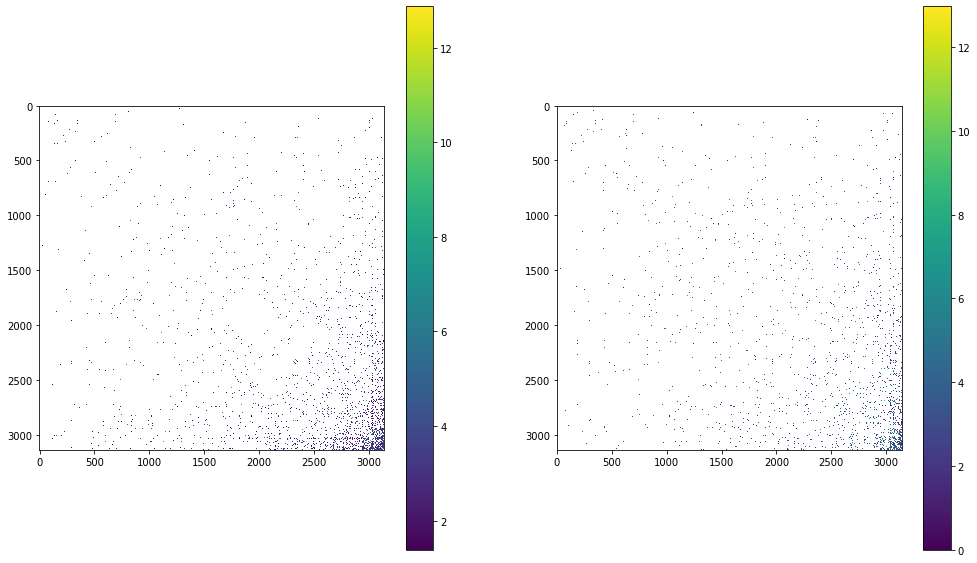

In [81]:
fig, (ax1,ax2) = plt.subplots(figsize=(17, 10), ncols=2)
pos = ax1.imshow(np.log(mob_current), cmap = 'viridis')
fig.colorbar(pos, ax=ax1)
pos = ax2.imshow(np.log(mob_new), cmap = 'viridis')
fig.colorbar(pos, ax=ax2)

In [57]:
a = mob_current.flatten()
a.sort()
a[-5:]

array([178031., 180838., 191402., 369522., 390387.])

In [42]:
np.where(mob_current == mob_current.max())

(array([3123]), array([3136]))

In [43]:
mob_current.max()

390387.0

In [44]:
mob_current.shape

(3143, 3143)

In [64]:
mob_current

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0., 217., 503.],
       [  0.,   0.,   0., ..., 438.,   0., 543.],
       [  0.,   0.,   0., ..., 537., 409.,   0.]])

In [73]:
mobility_data = pd.read_csv('data/mobility_2020_04_29_ais.csv', converters={'ori': lambda x: str(x), 'dest': lambda x: str(x)})
mob_new = np.zeros((spatial_setup.nnodes, spatial_setup.nnodes))
for index, row in mobility_data.iterrows():
    try:
        mob_new[spatial_setup.nodenames.index(row['ori']),spatial_setup.nodenames.index(row['dest'])] = row['amount']
    except:
        if(str(row['ori'])[:2] != '72' and str(row['dest'])[:2] != '72'):
            print(row)
    

ori       69100
dest      66010
amount       10
Name: 132659, dtype: object
ori       78010
dest      78020
amount       10
Name: 134573, dtype: object
ori       78010
dest      78030
amount       17
Name: 134574, dtype: object
ori       78020
dest      78010
amount       10
Name: 134577, dtype: object
ori       78020
dest      78030
amount       48
Name: 134578, dtype: object
ori       78030
dest      78010
amount       14
Name: 134583, dtype: object
ori       78030
dest      78020
amount       44
Name: 134584, dtype: object


In [117]:
mobility_data = pd.read_csv('data/mobility_2020_04_29_ais.csv', converters={'ori': lambda x: str(x), 'dest': lambda x: str(x)})
#GU, 66000 Guam
#VI, 78000 Virgin Islands
#PR, 72000 Puerto Rico
#MP, 69000 Northern Mariana Islands
#AS, 60000 American Samoa
prefixes = ['66', '69', '60']#,'72','78'
new_mobility_data = pd.DataFrame(columns=mobility_data.columns)
#df = df.append({
#     "firstname": "John",
#     "lastname":  "Johny"
#      }, ignore_index=True)
for index, row in mobility_data.iterrows():
    if((str(row['ori'])[:2] in prefixes) and (str(row['dest'])[:2] not in prefixes)):
        print(row)
    elif((str(row['ori'])[:2] not in prefixes) and (str(row['dest'])[:2]  in prefixes)):
        print(row)
    elif((str(row['ori'])[:2] in prefixes) and (str(row['dest'])[:2]  in prefixes)):
        print(row)

ori       69100
dest      66010
amount       10
Name: 132659, dtype: object


In [126]:
mobility_data = pd.read_csv('data/mobility_2020_04_29_ais.csv', converters={'ori': lambda x: str(x), 'dest': lambda x: str(x)})
#GU, 66000 Guam
#VI, 78000 Virgin Islands
#PR, 72000 Puerto Rico
#MP, 69000 Northern Mariana Islands
#AS, 60000 American Samoa
prefixes = ['66', '69', '60','72','78']
fromTR = {}
toTR = {}
new_mobility_data = pd.DataFrame(columns=mobility_data.columns)

for index, row in mobility_data.iterrows():
    if((str(row['ori'])[:2] in prefixes) and (str(row['dest'])[:2] not in prefixes)):
        new_mobility_data = new_mobility_data.append({"ori": str(row['ori'])[:2] + '000',  
                                  "dest":    row['dest'],
                                  "amount":  row['amount']}, ignore_index=True)
    elif((str(row['ori'])[:2] not in prefixes) and (str(row['dest'])[:2]  in prefixes)):
        new_mobility_data = new_mobility_data.append({"ori":      row['ori'],  
                                  "dest": str(row['dest'])[:2] + '000',
                                  "amount":   row['amount']}, ignore_index=True)
    elif ((str(row['ori'])[:2] in prefixes) and (str(row['dest'])[:2]  in prefixes)):
        new_mobility_data = new_mobility_data.append({"ori":  str(row['ori'])[:2] + '000',
                                  "dest": str(row['dest'])[:2] + '000',
                                  "amount":   row['amount']}, ignore_index=True)
    else:
        new_mobility_data = new_mobility_data.append(row, ignore_index=True)

In [136]:
keeper = new_mobility_data[~new_mobility_data.duplicated(['ori', 'dest'])].reindex()

In [165]:
keeper_old = new_mobility_data[~new_mobility_data.duplicated(['ori', 'dest'])].reindex()

In [170]:
for idx, row in new_mobility_data[new_mobility_data.duplicated(['ori', 'dest'])].iterrows():
    keeper.loc[(keeper['ori'] == str(row['ori'])) & (keeper['dest'] == str(row['dest'])),'amount'] = keeper[(keeper['ori'] == str(row['ori'])) & (keeper['dest'] == str(row['dest']))]['amount']  + row['amount']

In [177]:
keeper[~(keeper['ori'] == keeper['dest'])].reindex().to_csv('data/mobility_ais_grouped.csv')

In [178]:
ss_terr=setup.SpatialSetup( setup_name=spatial_config["setup_name"].get(),
                            geodata_file='data/geodata_territories.csv',
                            mobility_file='data/mobility_ais_grouped.csv',
                            popnodes_key=spatial_config["popnodes"].get(),
                            nodenames_key=spatial_config["nodenames"].get())

/usr/local/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [185]:
scipy.sparse.save_npz('data/mobility_ais_grouped.npz', ss_terr.mobility)

In [182]:
import scipy

In [187]:
mobility = scipy.sparse.load_npz('data/mobility_ais_grouped.npz')


In [190]:
(mobility == ss_terr.mobility).all

AttributeError: all not found

In [105]:
a =np.abs(mob_new-mob_current)/np.maximum(mob_current, mob_new)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [109]:
a=np.abs(mob_new-mob_current)

In [110]:
np.nanmax(a)

405514.0

In [101]:
compare = [mob_current, mob_new]
for c in compare:
    print(f'nnz: {np.count_nonzero(c)}, max: {c.max()}, mean: {np.ma.masked_equal(c, 0).mean()}, max_idx:{np.where(c == c.max())}')

nnz: 165404, max: 390387.0, mean: 223.88728204880172, max_idx:(array([3123]), array([3136]))
nnz: 132582, max: 429343.0, mean: 298.1541084008387, max_idx:(array([3136]), array([3123]))


In [102]:
mob_current[3136,3123]

23829.0

In [103]:
mob_new[3123,3136]

27938.0